In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

import torch
import esm


In [3]:
from utils import helper

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [5]:
class ESM2():
    def __init__(self, model_path, device='cpu') -> None:
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet(model_path)
        self.batch_converter = self.alphabet.get_batch_converter()
        self.model.eval()
        self.device = device

        if self.device == 'gpu':
            self.model.cuda()

        self.tok_to_idx = self.alphabet.tok_to_idx
        self.idx_to_tok = {v:k for k,v in self.tok_to_idx.items()}

    def get_res(self, sequence):
        data = [
            ("protein1", sequence)
        ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        if self.device == 'gpu':
            batch_tokens = batch_tokens.cuda()

        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[33], return_contacts=True)

        return results

    def get_logits(self, sequence):

        results = self.get_res(sequence)
        return results['logits']

    def get_prob(self, sequence):
        logits = self.get_logits(sequence)
        prob = torch.nn.functional.softmax(logits, dim=-1)[0, 1:-1, :] # 1st and last are start and end tokens

        return prob.cpu().numpy()

In [6]:
esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt')

In [7]:
def get_embeddings_seq(sequences):
    embeddings = []
    for seq in tqdm(sequences):
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

In [8]:
root = '../..'
data_path = os.path.join(root, 'Data')

In [9]:
fasta_file = os.path.join(data_path, 'sequences_425.fasta')
meta_file = os.path.join(data_path, 'sequences_425.metadata.json')

In [10]:
records = helper.read_fasta(fasta_file)
seq_425_sequences = {}
for rec in records:
    seq_425_sequences[rec.id] = str(rec.seq)
    
with open(meta_file) as f:
    seq_425_meta = json.load(f)
seq_425_meta = pd.DataFrame(seq_425_meta).T

In [11]:
df = pd.concat([pd.DataFrame.from_dict(seq_425_sequences, orient='index', columns=['sequence']), seq_425_meta], axis=1)

In [12]:
embeddings = get_embeddings_seq(df['sequence'])

100%|██████████| 128/128 [04:03<00:00,  1.91s/it]


In [13]:
df['embeddings'] = list(embeddings)

In [14]:
df.head()

,sequence,esm2_650M_perplexity,activity,embeddings
seq_0_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.489924,10.552655,"[-0.02621314, -0.08718042, -0.08317378, 0.1298..."
seq_1_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.568502,9.338325,"[-0.027964618, -0.086735666, -0.08568832, 0.12..."
seq_2_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.499378,8.289414,"[-0.02771596, -0.088174716, -0.08482945, 0.130..."
seq_3_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.596867,7.007689,"[-0.022297397, -0.09509543, -0.083283156, 0.12..."
seq_4_L_425,ATAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPIMQVK...,3.550846,6.898567,"[-0.028365752, -0.087006845, -0.085807584, 0.1..."


In [15]:
embeddings.shape

(128, 1280)

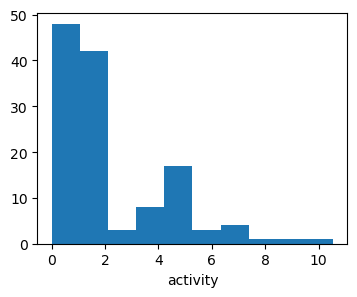

In [80]:
plt.figure(figsize=(4,3))
_ = plt.hist(df['activity'])
_ = plt.xlabel('activity')
plt.show()

In [203]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

from scipy.stats import uniform
from scipy.stats import spearmanr

In [18]:
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [26]:
y = df['activity'].to_numpy().reshape(-1,1)
X = embeddings.copy()
y_binned = binner.fit_transform(y)

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


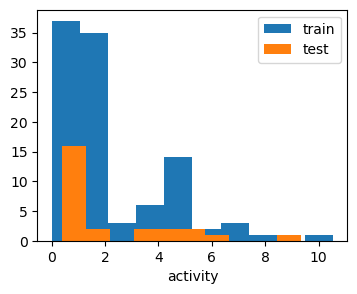

In [118]:
for train_index, test_index in skf.split(X, y_binned):
    break

X_train = X[train_index]
y_train = y[train_index]
y_binned_train = y_binned[train_index]

X_test = X[test_index]
y_test = y[test_index]
y_binned_test = y_binned[test_index]

fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.hist(y_train, label='train')
ax.hist(y_test, label='test')
ax.legend()
ax.set_xlabel('activity')
plt.show()

In [119]:
print(f'train set size: {train_index.shape[0]}')
print(f'test set size: {test_index.shape[0]}')

train set size: 102
test set size: 26


/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


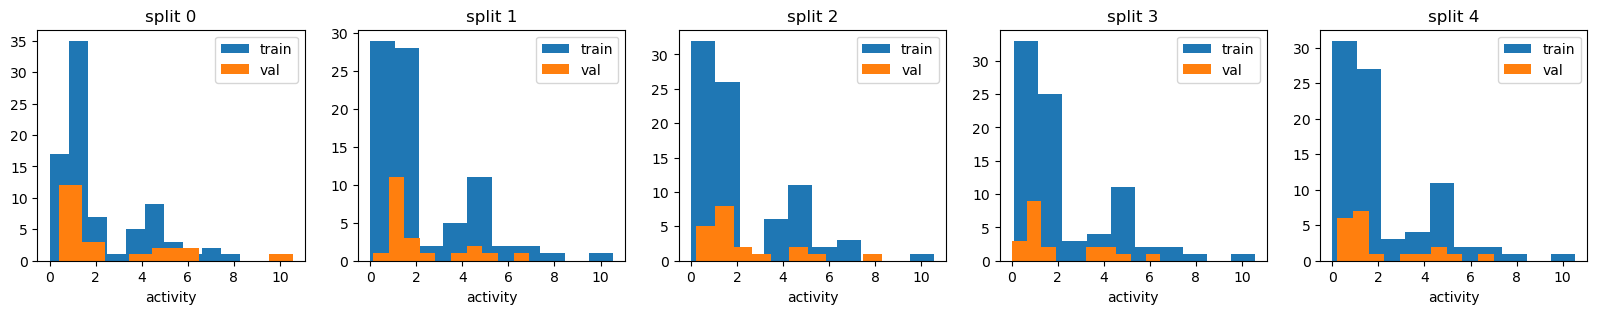

In [120]:
fig, ax = plt.subplots(1, 5, figsize=(20,3))
for i, (train_index, val_index) in enumerate(skf.split(X_train, y_binned_train)):
    ax[i].set_title(f'split {i}')
    ax[i].hist(y_train[train_index], label='train')
    ax[i].hist(y_train[val_index], label='val')
    ax[i].legend()
    ax[i].set_xlabel('activity')
plt.show()

#### Ridge

In [121]:
param_space = {
    'alpha': uniform(loc=0, scale=10),
}
ridge = Ridge(random_state=0)
clf = RandomizedSearchCV(ridge, param_space, n_iter=100, cv=skf.split(X_train, y_binned_train), scoring='r2', random_state=0)

In [122]:
search = clf.fit(X_train, y_train)

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


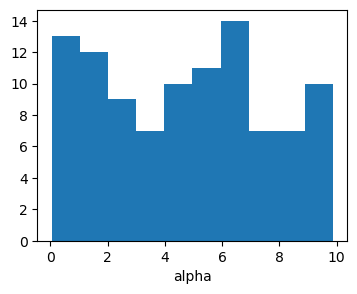

In [123]:
plt.figure(figsize=(4,3))
plt.hist([i['alpha'] for i in search.cv_results_['params']])
plt.xlabel('alpha')
plt.show()

In [124]:
alpha = search.best_params_['alpha']

In [125]:
alpha

0.046954761925470656

In [126]:
ridge = Ridge(alpha=alpha, random_state=0)
ridge.fit(X_train, y_train)
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

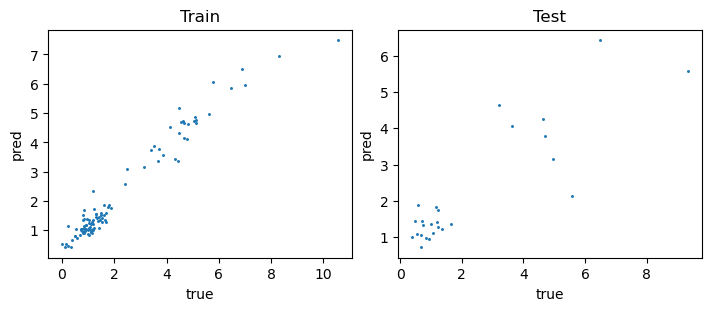

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), layout='constrained')

ax[0].scatter(y_train, y_pred_train, marker='.', s=5)
ax[1].scatter(y_test, y_pred_test, marker='.', s=5)

ax[0].set_xlabel('true')
ax[1].set_xlabel('true')
ax[0].set_ylabel('pred')
ax[1].set_ylabel('pred')
ax[0].set_title('Train')
ax[1].set_title('Test')

plt.show()

In [189]:
param_space = {
    'n_estimators': np.linspace(100, 1000, 19, dtype=int),
    'max_depth': np.linspace(10, 100, 10, dtype=int),
    'min_samples_leaf': np.concatenate([np.array([1], dtype=int), np.linspace(2, 20, 10, dtype=int)]),
    'min_samples_split': np.linspace(2, 20, 10, dtype=int),
    'max_features': np.linspace(0.1, 1.0, 10),
    'max_leaf_nodes': [10, 50, 100]
}
rf_regressor = RandomForestRegressor(random_state=0)
clf = RandomizedSearchCV(rf_regressor, param_space, n_iter=100, n_jobs=8, cv=skf.split(X_train, y_binned_train), random_state=0)

In [190]:
search = clf.fit(X_train, y_train.flatten())

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [192]:
search.best_params_

{'n_estimators': 700,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 10,
 'max_features': 0.2,
 'max_depth': 100}

In [213]:
rf_params = {'n_estimators': 700,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 10,
 'max_features': 0.2,
 'max_depth': 100}

In [214]:
rf_regressor = RandomForestRegressor(random_state=0, **rf_params)
rf_regressor_default = RandomForestRegressor(random_state=0)

rf_regressor.fit(X_train, y_train.flatten())
rf_regressor_default.fit(X_train, y_train.flatten())

y_pred_train = rf_regressor.predict(X_train)
y_pred_test = rf_regressor.predict(X_test)

y_pred_train_default = rf_regressor_default.predict(X_train)
y_pred_test_default = rf_regressor_default.predict(X_test)

Text(0.5, 1.0, 'Test \n spearmanr corr = 0.72 \n mse = 1.67')

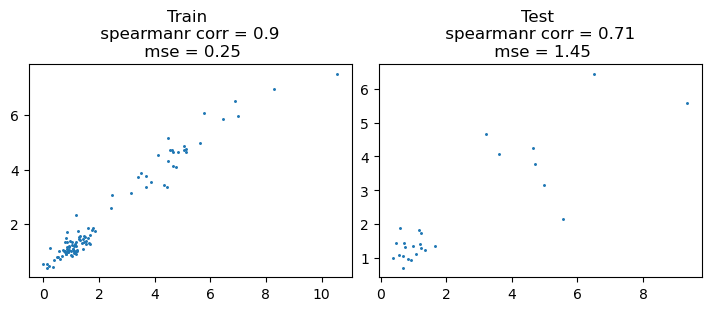

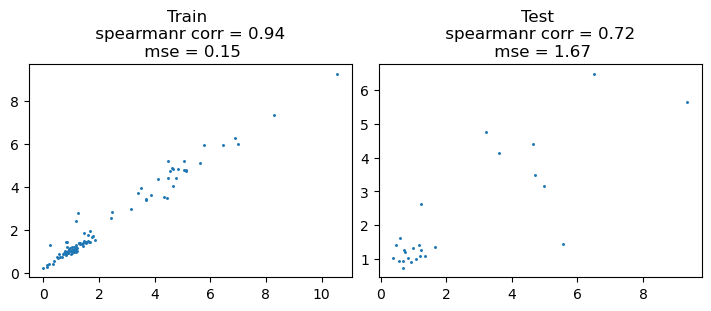

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), layout='constrained')

ax[0].scatter(y_train, y_pred_train, marker='.', s=5)
ax[0].set_title(f'Train \n spearmanr corr = {round(spearmanr(y_train.flatten(), y_pred_train).statistic, 2)} \n mse = {round(mean_squared_error(y_train.flatten(), y_pred_train), 2)}')
ax[1].scatter(y_test, y_pred_test, marker='.', s=5)
ax[1].set_title(f'Test \n spearmanr corr = {round(spearmanr(y_test.flatten(), y_pred_test).statistic, 2)} \n mse = {round(mean_squared_error(y_test.flatten(), y_pred_test), 2)}')

fig, ax = plt.subplots(1, 2, figsize=(7,3), layout='constrained')

ax[0].scatter(y_train, y_pred_train_default, marker='.', s=5)
ax[0].set_title(f'Train \n spearmanr corr = {round(spearmanr(y_train.flatten(), y_pred_train_default).statistic, 2)} \n mse = {round(mean_squared_error(y_train.flatten(), y_pred_train_default), 2)}')
ax[1].scatter(y_test, y_pred_test_default, marker='.', s=5)
ax[1].set_title(f'Test \n spearmanr corr = {round(spearmanr(y_test.flatten(), y_pred_test_default).statistic, 2)} \n mse = {round(mean_squared_error(y_test.flatten(), y_pred_test_default), 2)}')